# 0x07 Convolutional Neural Networks

Convolutional Neural Networks (CNNs) are a class of deep neural networks that are particularly effective for image processing tasks.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F  # noqa: N812

## 1. Translation equivariance
One of the key properties of CNNs is translation equivariance, i.e. the **same set** of pixel values (say, a certain object like a computer) at **different locations** in the image will produce the **same output pattern** in the feature map, but only shifted correspondingly in space.

Let us create a simple example to illustrate this.

First, let us create a simple image. It is a grayscale image of 9x9.

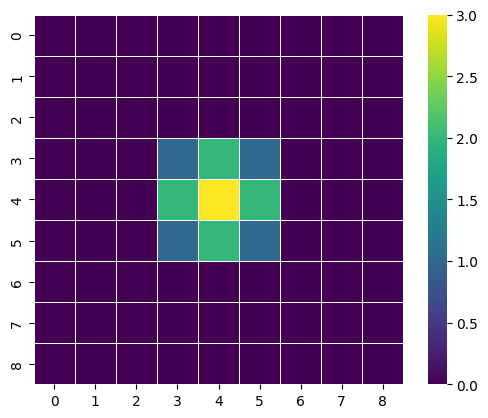

In [2]:
# Create a simple 2D image (batch_size=1, channels=1, height, width)
# We create 4-dim tensor just to feed it later to the conv2d layer
image = torch.zeros(1, 1, 9, 9)
# Create a simple pattern in the image
image[0, 0, 3:6, 3:6] = torch.tensor(
    [[1.0, 2.0, 1.0], [2.0, 3.0, 2.0], [1.0, 2.0, 1.0]]
)

sns.heatmap(image[0, 0], cmap="viridis", square=True, linewidths=0.5)
plt.show()

Nice! Now, let us create a shifted version of this image.

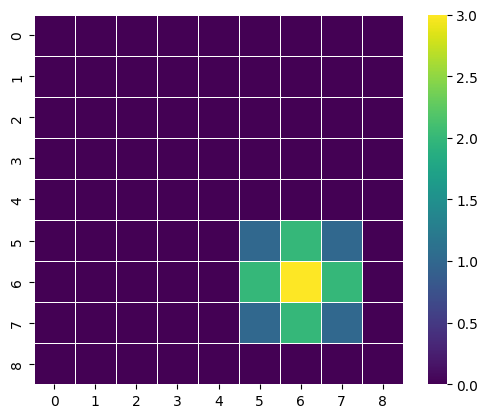

In [3]:
shifted_image = torch.roll(
    image,
    shifts=(2, 2),  # Shift the image by 2 pixels in both dimensions
    dims=(
        2,
        3,
    ),  # Specify the dimensions to shift, here the index-2 and index-3 dimensions
)
sns.heatmap(shifted_image[0, 0], cmap="viridis", square=True, linewidths=0.5)
plt.show()

Let us create a convolution kernel!

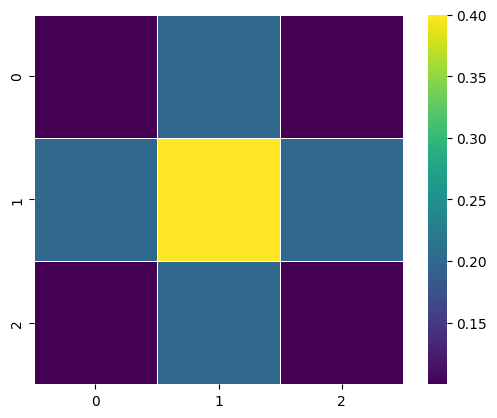

In [4]:
# Create a 2D kernel (out_channels=1, in_channels=1, kernel_height, kernel_width)
kernel = torch.tensor([[0.1, 0.2, 0.1], [0.2, 0.4, 0.2], [0.1, 0.2, 0.1]]).reshape(
    1, 1, 3, 3
)

sns.heatmap(kernel[0, 0], cmap="viridis", square=True, linewidths=0.5)
plt.show()

Now let's do a full set of visualizations to get a feel of translation equivariance.

In [5]:
# F.conv2d is a PyTorch function that applies a 2D convolution over an input image
result = F.conv2d(input=image, weight=kernel, stride=1, padding=1)
shifted_result = F.conv2d(input=shifted_image, weight=kernel, stride=1, padding=1)

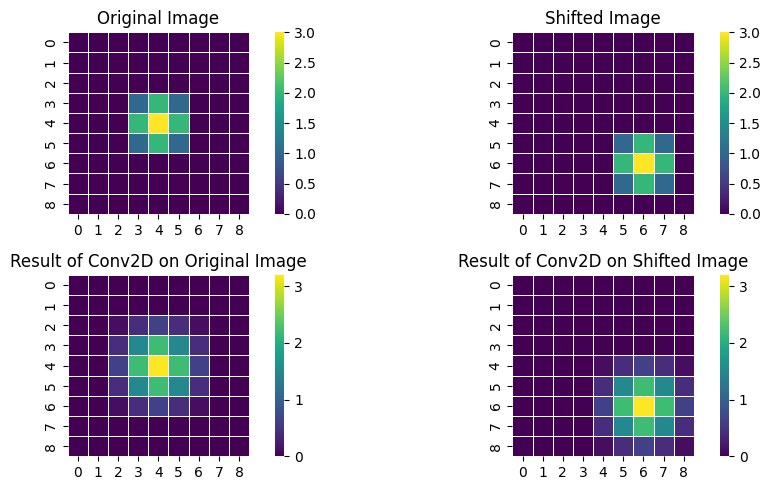

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
sns.heatmap(image[0, 0], cmap="viridis", square=True, linewidths=0.5, ax=axes[0, 0])
sns.heatmap(
    shifted_image[0, 0], cmap="viridis", square=True, linewidths=0.5, ax=axes[0, 1]
)
sns.heatmap(result[0, 0], cmap="viridis", square=True, linewidths=0.5, ax=axes[1, 0])
sns.heatmap(
    shifted_result[0, 0], cmap="viridis", square=True, linewidths=0.5, ax=axes[1, 1]
)
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Shifted Image")
axes[1, 0].set_title("Result of Conv2D on Original Image")
axes[1, 1].set_title("Result of Conv2D on Shifted Image")
plt.tight_layout()
plt.show()

> 📚 **EXERCISE**
>
> 1. What is the effect of the kernel on the image?
> 2. There are other kinds of kernels such as those which detects horizontal edges. Can you pick one and mimick the previous process to see its effect?

In [7]:
# === Your code here ===

## 2. Dissecting a real CNN

The previous example is a very simple introduction. How about we take a look at the effect of a real CNN on a real image?

We will use ResNet, one of the most popular CNN architectures. It is a deep residual network that has been shown to be very effective for image classification tasks.

We will take a relatively small net, ResNet-18. You can load it using `torchvision`.

In [8]:
import torchvision

# The ResNet-18 is already pretrained on ImageNet, a large dataset of image classification tasks.
resnet18 = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

To capture the activations of the first convolutional layer, we will use a PyTorch **hook**. 

A hook is a function that is called when a certain event occurs.
In this case, we will "hook" the function to the forward pass of the models, i.e. binding it to each layer of the model.

In [9]:
activations = {}


def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()

    return hook

In [10]:
# Register hooks for all conv layers
for name, module in resnet18.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        module.register_forward_hook(get_activation(name))

Let us take a look at this beautiful Jellyfish! (Author: Tetyana Andruz, Unsplash License)

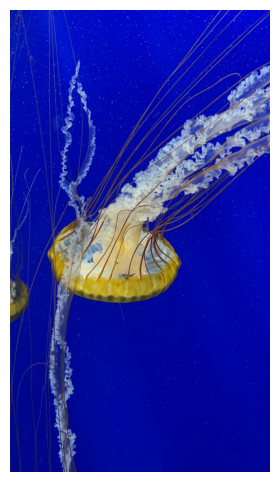

In [11]:
import matplotlib.image as mpimg

# Load and display in one cell
img = mpimg.imread("data/jellyfish.jpg")
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

First. let us preprocess the image.

In [12]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Remember the normalization chapter?
    ]
)

# Load the image
img_tensor = torchvision.io.read_image("data/jellyfish.jpg")
# Normalize the image
img_tensor = img_tensor.float() / 255.0
# Apply the transformations
img_tensor = transform(img_tensor)
# Add batch dimension
img_tensor = img_tensor.unsqueeze(0)
# Check the shape
print(img_tensor.shape)  # Should be [1, 3, 224, 224]

torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2424958].


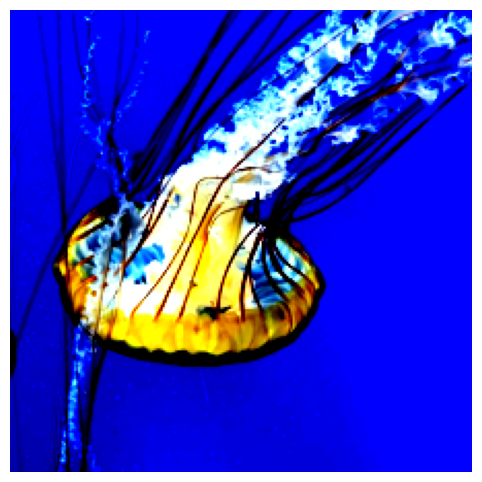

In [13]:
# Visualize the image
plt.figure(figsize=(8, 6))
plt.imshow(img_tensor[0].permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
plt.axis("off")
plt.show()

In [14]:
# Run a forward pass to get the activations
resnet18.eval()  # Set the model to evaluation mode
with torch.no_grad():
    out = resnet18(img_tensor)

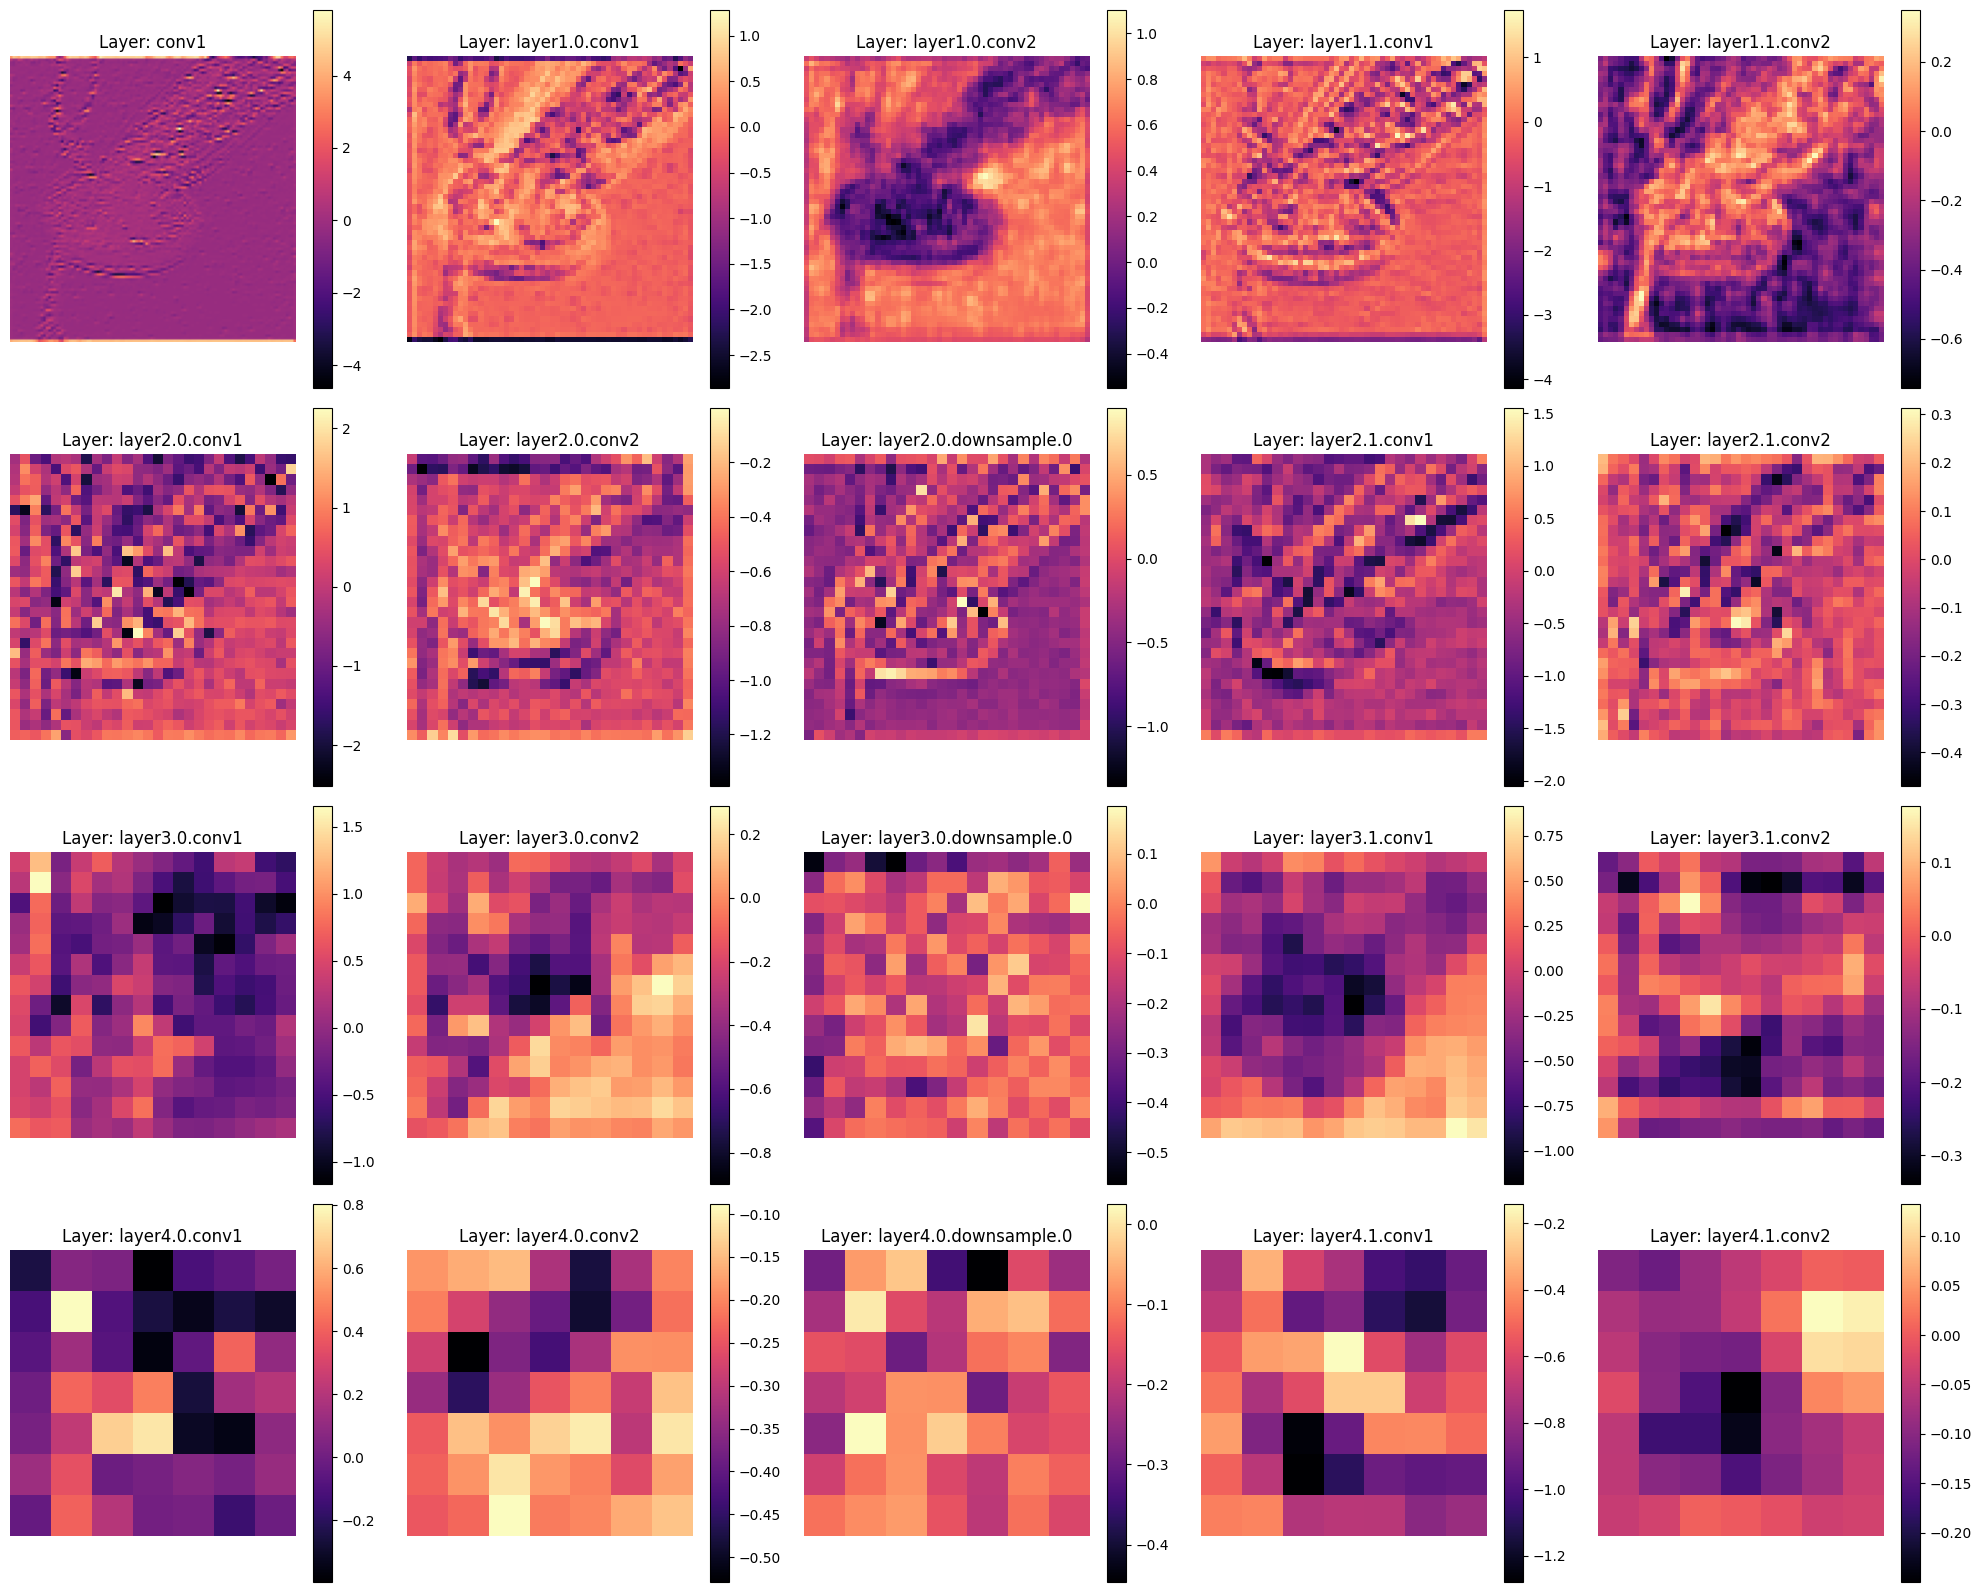

In [15]:
plt.figure(figsize=(20, 20))
for i, (name, act) in enumerate(activations.items()):
    # Get the first channel (index 0) from the first item in batch
    first_channel = act[0, 0].cpu().numpy()

    plt.subplot(5, 5, i + 1)  # Adjust grid size based on number of layers
    plt.imshow(first_channel, cmap="magma")
    plt.colorbar()
    plt.title(f"Layer: {name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
# Check the output of the model
print(out.shape)  # Should be [1, 1000] for ImageNet classification
# Get the predicted class
_, predicted = torch.max(out, 1)
print(f"Predicted class index: {predicted.item()}")

torch.Size([1, 1000])
Predicted class index: 107


If you check the [ImageNet index](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)...
Yes! No. 107 is a jellyfish!

> 🤔 **THINKING**
>
> - Observe the activations of the shallower layers and compare them to the deeper layers. What do you observe?
> - Prepare another image to input into the model. Observe the activations. Did you find any similar patterns?

## 3. GradCAM on CNN: Explaining model's decision

You may want to ask: why is this model making this decision?

One way to explain the model's decision is to use Gradient-weighted Class Activation Mapping, or **GradCAM** (https://arxiv.org/abs/1610.02391).

In short, GradCAM is a technique that uses the **gradients of the output with respect to the feature map** (usually,  in the CNN case, the last convolution layer output)
to produce a heatmap that highlights the important regions in the image.

In other words, it shows how much this region of the image contributes to the final decision of the model.

In [17]:
# Load the image
img_tensor = torchvision.io.read_image("data/jellyfish.jpg")
# Normalize the image
img_tensor = img_tensor.float() / 255.0
# Apply the transformations
img_tensor = transform(img_tensor)
# Add batch dimension
img_tensor = img_tensor.unsqueeze(0)
# Check the shape
print(img_tensor.shape)  # Should be [1, 3, 224, 224]

torch.Size([1, 3, 224, 224])


In [18]:
# Load the image for overlay visualization
viz_base_img = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ]
)(torchvision.io.read_image("data/jellyfish.jpg"))

viz_base_img = viz_base_img.float() / 255.0
viz_base_img = viz_base_img.permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
viz_base_img = viz_base_img.numpy()  # Convert to numpy array

print(viz_base_img.shape)

(224, 224, 3)


In [19]:
# The Grad-CAM package
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Define target for the grad-cam, here, the index of the predicted class
# Remember that jellyfish is class 107.
targets = [ClassifierOutputTarget(107)]

# Create a new ResNet-18 model
model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
)
model.eval()

# Let us create a GradCAM
target_layers = [model.layer4[-1]]  # The last conv layer of ResNet-18
with GradCAM(model=model, target_layers=target_layers) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(viz_base_img, grayscale_cam, use_rgb=True)
    # You can also get the model outputs without having to redo inference
    model_outputs = cam.outputs

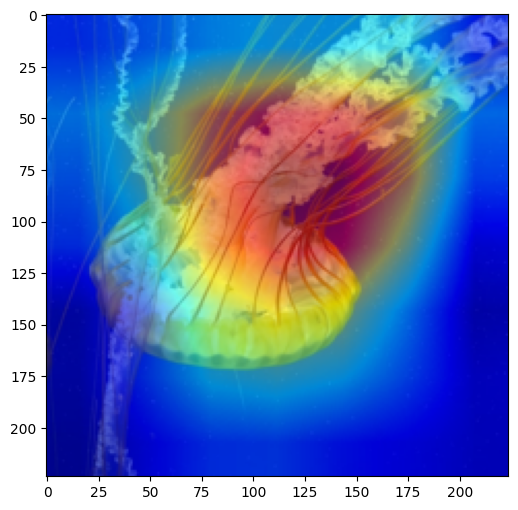

In [20]:
# Visualize the Grad-CAM
plt.figure(figsize=(8, 6))
plt.imshow(visualization)
plt.show()

You can interpret this picture as:

When the model classifies this image **as a jellyfish**, which part of the image is most important for this decision?

If you change the target class to, say, a cat, then the generated heatmap will be explained as "when the model classifies this image as a cat, which part of the image is most important for this decision?".

> 🤔 **THINKING**
>
> - Take a look at this picture. What do you think is the key feature that the model thinks is important to classify this image as a jellyfish?

> 📚 **EXERCISE**
>
> - Try to change the target class to another class (`targets = [ClassifierOutputTarget(<class_idx>)]`). What do you observe? 
> - Try to validate the effectiveness of GradCAM by trying out other combinations of images and target classes.

In [21]:
# === Your code here ===